In [3]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [4]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [5]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [185]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [196]:
def cost_execution(params):
    params = np.reshape(params, (2, 1))

    global iterations

    cost = CVaRsamp(params, alpha=a, n=num_of_samples)

    #if iterations % 50 == 0:
    print("Cost at Step {}: {}".format(iterations, cost))
    
    params_list.append(params)
    cost_list.append(cost)

    iterations += 1
    return cost

In [210]:
counter = 0
j=0
num_of_samples=1000
a=0.25

prob_list_list = []
cost_list_list = []
iter_needed_list_alpha005 = []

for j in range(30):
    params_list = []
    cost_list = []
    iterations = 0

    initial_params=np.array([[0.42429616], [4.32654011]], requires_grad = True)
    print(initial_params.shape)
    out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)
    out_params = np.reshape(out["x"], (2, 1))
    #out_params = np.transpose(out_params)
    print(out["x"])
    print(out["success"])
    probs = get_probs(out_params)
    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

    prob_list = []
    for i in range(len(params_list)):
        p = get_probs(params_list[i])
        prob_list.append(float(np.sum(p[ground_states_i])))
        
    prob_list_list.append(prob_list)
    cost_list_list.append(cost_list)
    iter_needed_list_alpha005.append(iterations)


    #if np.sum(probs[ground_states_i]) < 0.05:
    counter+=1
    print('Try ' + str(j) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
    #print('For: ' + str(num_of_samples) + ' samples, the prob of measuring any groundstate was at least 5% : ' + str(j-counter) + ' times out of ' + str(j) + ' tries.')
    print("="*20)

(2, 1)
Cost at Step 0: -5.968800000000011
Cost at Step 1: -2.474799999999999
Cost at Step 2: -1.6819999999999955


/var/folders/cw/p649yvnd6tl_8jn4s2cchc7m0000gn/T/ipykernel_11477/1489850601.py:17: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)


Cost at Step 3: -5.4324000000000146
Cost at Step 4: -3.3828000000000054
Cost at Step 5: -5.254800000000022
Cost at Step 6: -4.574800000000019
Cost at Step 7: -5.730000000000024
Cost at Step 8: -6.091200000000003
Cost at Step 9: -5.577600000000026
Cost at Step 10: -5.870400000000015
Cost at Step 11: -5.9028000000000125
Cost at Step 12: -5.896800000000015
Cost at Step 13: -6.010800000000009
Cost at Step 14: -6.1512
Cost at Step 15: -5.936400000000012
[0.4048871  4.40171699]
True
Try 0: Success probability of training:  0.1741161888613963
(2, 1)
Cost at Step 0: -6.369599999999989
Cost at Step 1: -2.5607999999999955
Cost at Step 2: -1.6539999999999964
Cost at Step 3: -5.341200000000014
Cost at Step 4: -3.2660000000000022
Cost at Step 5: -5.41200000000002
Cost at Step 6: -4.8296000000000205
Cost at Step 7: -5.720400000000025
Cost at Step 8: -5.7216000000000244
Cost at Step 9: -6.009600000000009
Cost at Step 10: -5.851200000000018
Cost at Step 11: -6.0456000000000065
Cost at Step 12: -6.162


Cost at Step 4: -3.515600000000005
Cost at Step 5: -5.30640000000002
Cost at Step 6: -4.952000000000023
Cost at Step 7: -5.677200000000026
Cost at Step 8: -6.103200000000003
Cost at Step 9: -6.002400000000008
Cost at Step 10: -6.055200000000006
Cost at Step 11: -6.208799999999997
Cost at Step 12: -6.093600000000004
Cost at Step 13: -6.315599999999991
Cost at Step 14: -6.190799999999998
Cost at Step 15: -6.038400000000007
[0.43771945 4.34752612]
True
Try 12: Success probability of training:  0.19432132552280623
(2, 1)
Cost at Step 0: -6.082800000000005
Cost at Step 1: -2.3512000000000026
Cost at Step 2: -1.661599999999994
Cost at Step 3: -5.544000000000009
Cost at Step 4: -3.472000000000003
Cost at Step 5: -5.332800000000019
Cost at Step 6: -4.8784000000000205
Cost at Step 7: -5.868000000000016
Cost at Step 8: -5.821200000000019
Cost at Step 9: -6.087600000000004
Cost at Step 10: -6.1236000000000015
Cost at Step 11: -6.0888000000000035
Cost at Step 12: -5.948400000000012
Cost at Step 13

Cost at Step 12: -5.845200000000018
Cost at Step 13: -5.8992000000000155
Cost at Step 14: -6.062400000000006
Cost at Step 15: -6.026400000000008
[0.36199199 4.30863992]
True
Try 24: Success probability of training:  0.18526050484444728
(2, 1)
Cost at Step 0: -5.920800000000014
Cost at Step 1: -2.5347999999999957
Cost at Step 2: -1.774399999999996
Cost at Step 3: -5.208000000000015
Cost at Step 4: -3.5536000000000043
Cost at Step 5: -5.455200000000019
Cost at Step 6: -4.829200000000021
Cost at Step 7: -5.772000000000022
Cost at Step 8: -5.778000000000021
Cost at Step 9: -6.177599999999998
Cost at Step 10: -5.828400000000017
Cost at Step 11: -6.099600000000003
Cost at Step 12: -6.1416
Cost at Step 13: -6.000000000000008
Cost at Step 14: -5.842800000000017
Cost at Step 15: -6.070800000000004
[0.48538041 4.29811114]
True
Try 25: Success probability of training:  0.1922496174324222
(2, 1)
Cost at Step 0: -6.043200000000007
Cost at Step 1: -2.3836000000000017
Cost at Step 2: -1.6903999999999

In [191]:
counter = 0
j=0
num_of_samples=1000
a=1

prob_list_list_alpha1 = []
iter_needed_list_alpha1 = []

for j in range(30):
    params_list = []
    iterations = 0

    initial_params=np.array([[0.42429616], [4.32654011]], requires_grad = True)
    print(initial_params.shape)
    out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)
    out_params = np.reshape(out["x"], (2, 1))
    #out_params = np.transpose(out_params)
    print(out["x"])
    print(out["success"])
    probs = get_probs(out_params)
    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

    prob_list = []
    for i in range(len(params_list)):
        p = get_probs(params_list[i])
        prob_list.append(float(np.sum(p[ground_states_i])))
        
    prob_list_list_alpha1.append(prob_list)
    iter_needed_list_alpha1.append(iterations)


    #if np.sum(probs[ground_states_i]) < 0.05:
    counter+=1
    print('Try ' + str(j) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
    #print('For: ' + str(num_of_samples) + ' samples, the prob of measuring any groundstate was at least 5% : ' + str(j-counter) + ' times out of ' + str(j) + ' tries.')
    print("="*20)

(2, 1)
Cost at Step 0: -2.5315999999999725
Cost at Step 1: 0.804999999999998
Cost at Step 2: 2.009699999999993


/var/folders/cw/p649yvnd6tl_8jn4s2cchc7m0000gn/T/ipykernel_11477/2896318904.py:15: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)


Cost at Step 3: -2.349900000000007
Cost at Step 4: 0.40949999999999837
Cost at Step 5: -1.6931999999999954
Cost at Step 6: -1.4339999999999935
Cost at Step 7: -2.0899999999999745
Cost at Step 8: -2.488299999999979
Cost at Step 9: -2.4938999999999836
Cost at Step 10: -2.5207999999999755
Cost at Step 11: -2.6748999999999743
Cost at Step 12: -2.5514999999999772
Cost at Step 13: -2.497499999999978
Cost at Step 14: -2.5872999999999733
[0.42526841 4.31617504]
True
Try 0: Success probability of training:  0.1971991462196986
(2, 1)
Cost at Step 0: -2.4387999999999854
Cost at Step 1: 0.870999999999999
Cost at Step 2: 2.107499999999991
Cost at Step 3: -2.0841000000000016
Cost at Step 4: 0.55
Cost at Step 5: -1.7728999999999933
Cost at Step 6: -1.5588999999999957
Cost at Step 7: -2.29729999999997
Cost at Step 8: -2.628299999999969
Cost at Step 9: -2.3878999999999797
Cost at Step 10: -2.398799999999981
Cost at Step 11: -2.339399999999972
Cost at Step 12: -2.443899999999979
Cost at Step 13: -2.5110

Cost at Step 3: -1.9476999999999964
Cost at Step 4: 0.4647999999999998
Cost at Step 5: -1.9202999999999906
Cost at Step 6: -1.4485999999999892
Cost at Step 7: -2.15019999999997
Cost at Step 8: -2.709799999999983
Cost at Step 9: -2.379499999999987
Cost at Step 10: -2.409799999999981
Cost at Step 11: -2.6746999999999828
Cost at Step 12: -2.5275999999999814
Cost at Step 13: -2.671999999999981
Cost at Step 14: -2.498199999999986
[0.41914244 4.39328527]
True
Try 12: Success probability of training:  0.1794712789489445
(2, 1)
Cost at Step 0: -2.570299999999975
Cost at Step 1: 0.8770999999999975
Cost at Step 2: 2.0451999999999937
Cost at Step 3: -2.21940000000001
Cost at Step 4: 0.534500000000001
Cost at Step 5: -1.7900999999999958
Cost at Step 6: -1.4619999999999953
Cost at Step 7: -2.2637999999999656
Cost at Step 8: -2.557199999999987
Cost at Step 9: -2.6610999999999785
Cost at Step 10: -2.476799999999985
Cost at Step 11: -2.6411999999999782
Cost at Step 12: -2.583799999999982
Cost at Step 

Cost at Step 3: -2.1437000000000053
Cost at Step 4: 0.4559999999999988
Cost at Step 5: -1.788799999999996
Cost at Step 6: -1.502799999999995
Cost at Step 7: -2.1291999999999764
Cost at Step 8: -2.5240999999999736
Cost at Step 9: -2.6609999999999867
Cost at Step 10: -2.5540999999999894
Cost at Step 11: -2.507299999999988
Cost at Step 12: -2.5480999999999843
Cost at Step 13: -2.5682999999999843
Cost at Step 14: -2.65069999999999
Cost at Step 15: -2.617799999999984
Cost at Step 16: -2.5585999999999918
[0.44427093 4.39515984]
True
Try 24: Success probability of training:  0.1801343553975038
(2, 1)
Cost at Step 0: -2.461699999999976
Cost at Step 1: 1.0952999999999986
Cost at Step 2: 2.131999999999992
Cost at Step 3: -2.3807000000000147
Cost at Step 4: 0.3448000000000003
Cost at Step 5: -1.9166999999999916
Cost at Step 6: -1.4611999999999892
Cost at Step 7: -2.108699999999969
Cost at Step 8: -2.630299999999977
Cost at Step 9: -2.42799999999999
Cost at Step 10: -2.416999999999982
Cost at Step

In [193]:
counter = 0
j=0
num_of_samples=32
a=0.2

prob_list_list_alpha02 = []
iter_needed_list_alpha02 = []

for j in range(30):
    iterations = 0
    params_list = []

    initial_params=np.array([[0.42429616], [4.32654011]], requires_grad = True)
    print(initial_params.shape)
    out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)
    out_params = np.reshape(out["x"], (2, 1))
    #out_params = np.transpose(out_params)
    print(out["x"])
    print(out["success"])
    probs = get_probs(out_params)
    ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

    prob_list = []
    for i in range(len(params_list)):
        p = get_probs(params_list[i])
        prob_list.append(float(np.sum(p[ground_states_i])))
        
    prob_list_list_alpha02.append(prob_list)
    iter_needed_list_alpha02.append(iterations)


    #if np.sum(probs[ground_states_i]) < 0.05:
    counter+=1
    print('Try ' + str(j) + ': Success probability of training: ', np.sum(probs[ground_states_i]))
    #print('For: ' + str(num_of_samples) + ' samples, the prob of measuring any groundstate was at least 5% : ' + str(j-counter) + ' times out of ' + str(j) + ' tries.')
    print("="*20)

(2, 1)
Cost at Step 0: -6.6000000000000005
Cost at Step 1: -2.1
Cost at Step 2: -2.433333333333333


/var/folders/cw/p649yvnd6tl_8jn4s2cchc7m0000gn/T/ipykernel_11477/1062375001.py:15: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(cost_execution, x0=initial_params, method="COBYLA", options={"maxiter": 100}, tol=0.01)


Cost at Step 3: -6.25
Cost at Step 4: -4.433333333333333
Cost at Step 5: -5.5
Cost at Step 6: -4.133333333333333
Cost at Step 7: -6.2
Cost at Step 8: -5.8
Cost at Step 9: -6.6000000000000005
Cost at Step 10: -6.6000000000000005
Cost at Step 11: -6.6000000000000005
Cost at Step 12: -6.2
Cost at Step 13: -6.6000000000000005
[0.42912833 4.33529511]
True
Try 0: Success probability of training:  0.1959250207182865
(2, 1)
Cost at Step 0: -6.2
Cost at Step 1: -2.8666666666666667
Cost at Step 2: -3.416666666666666
Cost at Step 3: -5.2
Cost at Step 4: -4.516666666666667
Cost at Step 5: -5.55
Cost at Step 6: -4.6
Cost at Step 7: -6.2
Cost at Step 8: -6.6000000000000005
Cost at Step 9: -6.25
Cost at Step 10: -6.6000000000000005
Cost at Step 11: -6.6000000000000005
Cost at Step 12: -5.8
Cost at Step 13: -6.6000000000000005
Cost at Step 14: -5.8
Cost at Step 15: -6.2
[0.36975352 4.35865475]
True
Try 1: Success probability of training:  0.18110078869179452
(2, 1)
Cost at Step 0: -6.2
Cost at Step 1:

Try 14: Success probability of training:  0.1952685315987536
(2, 1)
Cost at Step 0: -6.6000000000000005
Cost at Step 1: -2.5166666666666666
Cost at Step 2: -2.2833333333333337
Cost at Step 3: -5.55
Cost at Step 4: -2.966666666666667
Cost at Step 5: -5.8500000000000005
Cost at Step 6: -6.25
Cost at Step 7: -5.05
Cost at Step 8: -6.2
Cost at Step 9: -4.999999999999999
Cost at Step 10: -6.6000000000000005
Cost at Step 11: -6.6000000000000005
Cost at Step 12: -6.6000000000000005
[0.42429616 4.32654011]
True
Try 15: Success probability of training:  0.19655627407715742
(2, 1)
Cost at Step 0: -6.2
Cost at Step 1: -3.883333333333334
Cost at Step 2: -3.516666666666667
Cost at Step 3: -6.6000000000000005
Cost at Step 4: -3.733333333333333
Cost at Step 5: -3.3000000000000003
Cost at Step 6: -6.25
Cost at Step 7: -6.6000000000000005
Cost at Step 8: -3.9
Cost at Step 9: -4.8500000000000005
Cost at Step 10: -6.25
Cost at Step 11: -5.1499999999999995
Cost at Step 12: -5.8999999999999995
Cost at Step

Cost at Step 4: -4.416666666666667
Cost at Step 5: -4.75
Cost at Step 6: -5.1
Cost at Step 7: -6.6000000000000005
Cost at Step 8: -5.3999999999999995
Cost at Step 9: -6.6000000000000005
Cost at Step 10: -6.6000000000000005
Cost at Step 11: -6.2
Cost at Step 12: -6.2
Cost at Step 13: -6.6000000000000005
Cost at Step 14: -5.8
Cost at Step 15: -5.8
[0.43110483 4.31921604]
True
Try 29: Success probability of training:  0.1973645615993155


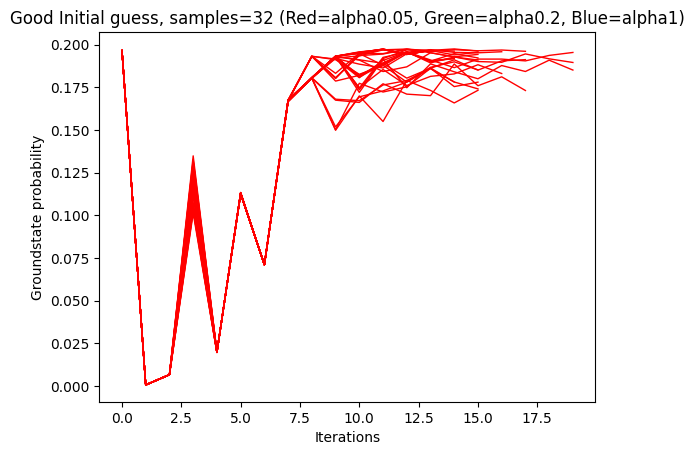

In [211]:
fig, ax = plt.subplots()
#for prob_vector in prob_list_list_alpha1:    
    #ax.plot(prob_vector, 'b', linewidth=1)
#for prob_vector in prob_list_list_alpha02:    
    #ax.plot(prob_vector, 'g', linewidth=1)
for prob_vector in prob_list_list:    
    ax.plot(prob_vector, 'r', linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.title('Good Initial guess, samples=32 (Red=alpha0.05, Green=alpha0.2, Blue=alpha1)')
#ax.legend()
#plt.plot()
plt.show()

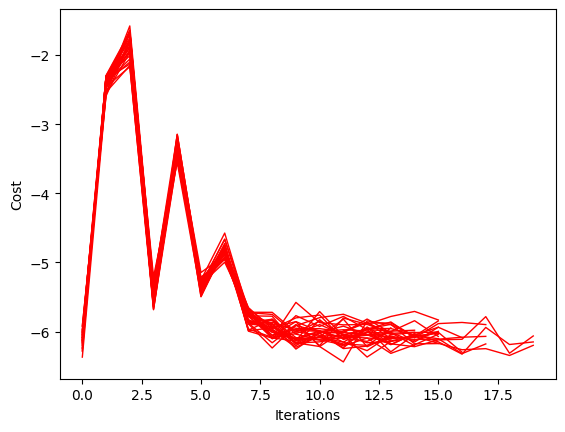

In [212]:
fig, ax = plt.subplots()
for cost_vector in cost_list_list:    
    ax.plot(cost_vector, 'r',linewidth=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
#plt.title('Good Initial guess, samples=32 (Red=alpha0.05, Green=alpha0.2, Blue=alpha1)')
#ax.legend()
#plt.plot()
plt.show()

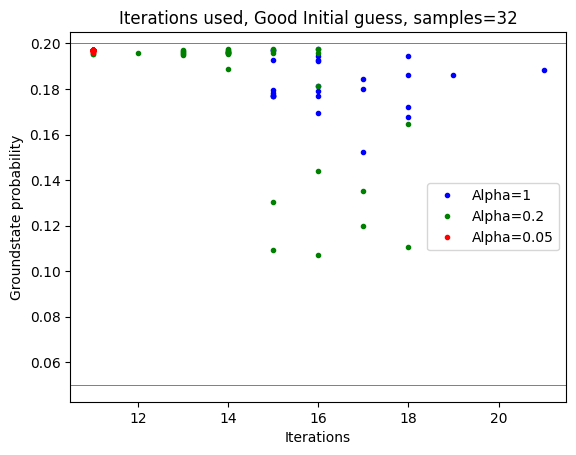

In [195]:
end_probs_alpha1 = []
for probs in prob_list_list_alpha1:     
    end_probs_alpha1.append(probs[-1])
    
end_probs_alpha005 = []
for probs in prob_list_list:     
    end_probs_alpha005.append(probs[-1])
                     
end_probs_alpha02 = []
for probs in prob_list_list_alpha02:     
    end_probs_alpha02.append(probs[-1])

fig, ax = plt.subplots()
ax.plot(iter_needed_list_alpha1, end_probs_alpha1, 'b.', label='Alpha=1')
ax.plot(iter_needed_list_alpha02, end_probs_alpha02, 'g.', label='Alpha=0.2')
ax.plot(iter_needed_list_alpha005, end_probs_alpha005, 'r.', label='Alpha=0.05')
ax.axhline(y=0.05, color='r', linewidth=0.5)
ax.axhline(y=0.2, color='g', linewidth=0.5)
ax.legend()
plt.xlabel('Iterations')
plt.ylabel('Groundstate probability')
plt.title('Iterations used, Good Initial guess, samples=32')
#ax.legend()

plt.show()

In [ ]:
np.array([1.68676116],[-0.06325354])